# 1. Introduction
### This project explores a dataset of cosmetic products and their ingredients. The goal is to clean the data, analyze ingredient usage, and uncover insights about patterns in cosmetic formulations.

### Key questions:
- What are the most common ingredients across products?
- Are there ingredients linked to specific product types (e.g., “moisturizer” vs. “treatment”)?
- How many ingredients are typically used per product?
- What are the highest rated brands and products in this dataset?

___

# 2. Load and Inspect Raw Data

In [20]:
import pandas as pd

df = pd.read_csv("data\cosmetic_p.csv")
df.head()
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   brand        1472 non-null   object 
 2   name         1472 non-null   object 
 3   price        1472 non-null   int64  
 4   rank         1472 non-null   float64
 5   ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\angel\AppData\Local\Temp\ipykernel_24756\2950240322.py:3: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv("data\cosmetic_p.csv")


,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive
count,1472,1472,1472,1472.000000,1472.000000,1472,1472.00000,1472.000000,1472.000000,1472.000000,1472.000000
unique,6,116,1472,NaN,NaN,1337,NaN,NaN,NaN,NaN,NaN
top,Moisturizer,CLINIQUE,Crème de la Mer,NaN,NaN,No Info,NaN,NaN,NaN,NaN,NaN
freq,298,79,1,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,55.584239,4.153261,NaN,0.65625,0.614130,0.652174,0.607337,0.513587
std,NaN,NaN,NaN,45.014429,0.633918,NaN,0.47512,0.486965,0.476442,0.488509,0.499985
min,NaN,NaN,NaN,3.000000,0.000000,NaN,0.00000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,30.000000,4.000000,NaN,0.00000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,42.500000,4.300000,NaN,1.00000,1.000000,1.000000,1.000000,1.000000
75%,NaN,NaN,NaN,68.000000,4.500000,NaN,1.00000,1.000000,1.000000,1.000000,1.000000


___

# 3. Data Cleaning and Wrangling
## Goals:
- Convert ingredients to string
- Remove special characters
- Split into lists
- Handle missing or malformed values
- Merge with API

In [2]:
import re

# Ensure 'ingredients' column is treated as string
df['ingredients'] = df['ingredients'].astype(str)

# Remove special characters
df['clean_ingredients'] = df['ingredients'].apply(lambda x: re.sub(r'[^a-zA-Z0-9,\s]', '', x))

# Split ingredients and strip whitespace
df['ingredient_list'] = df['clean_ingredients'].str.split(',')
df['ingredient_list'] = df['ingredient_list'].apply(lambda lst: [item.strip() for item in lst])

In [3]:
#Rename 'Label' to 'product_type'
df.rename(columns={'Label': 'product_type'}, inplace=True)

In [4]:
# Remove null values from rank and rating
df_cleaned = df.dropna()

In [5]:
import requests

# Load local dataset
df_local = pd.read_csv(r"data/cosmetic_p.csv")
# Clean brand/name for matching
df_local['brand_clean'] = df_local['brand'].str.lower().str.strip()
df_local['name_clean'] = df_local['name'].str.lower().str.strip()

# Fetch data from Makeup API
url = "http://makeup-api.herokuapp.com/api/v1/products.json"
resp = requests.get(url)
api_data = resp.json()
df_api = pd.DataFrame(api_data)

# Use all and merge only matching ones
df_api['brand_clean'] = df_api['brand'].fillna('').astype(str).str.lower().str.strip()
df_api['name_clean'] = df_api['name'].fillna('').astype(str).str.lower().str.strip()

# Merge datasets
df_merged = pd.merge(
    df_local,
    df_api[['brand_clean', 'name_clean', 'rating', 'product_type']],
    on=['brand_clean', 'name_clean'],
    how='left',
    suffixes=('_local', '_api')
)

# Inspect results
print("Merged shape:", df_merged.shape)
print(df_merged[['name', 'brand', 'rank', 'rating', 'product_type']].head(20))

Merged shape: (1472, 15)
                                                 name               brand  \
0                                     Crème de la Mer              LA MER   
1                            Facial Treatment Essence               SK-II   
2                          Protini™ Polypeptide Cream      DRUNK ELEPHANT   
3                         The Moisturizing Soft Cream              LA MER   
4       Your Skin But Better™ CC+™ Cream with SPF 50+        IT COSMETICS   
5                                     The Water Cream              TATCHA   
6                           Lala Retro™ Whipped Cream      DRUNK ELEPHANT   
7                     Virgin Marula Luxury Facial Oil      DRUNK ELEPHANT   
8                                  Ultra Facial Cream  KIEHL'S SINCE 1851   
9   Little Miss Miracle Limited-Edition Crème de l...              LA MER   
10                   Lotus Youth Preserve Moisturizer               FRESH   
11                      Midnight Recovery Concentra

In [6]:
# Overwrite original dataframe
df.dropna(inplace=True)

___

# 4. Exploratory Data Analysis (EDA)

In [7]:
# Summary stats
df['num_ingredients'] = df['ingredient_list'].apply(len)
df['num_ingredients'].describe()

count    1472.000000
mean       31.026495
std        22.343739
min         1.000000
25%        17.000000
50%        30.000000
75%        42.000000
max       220.000000
Name: num_ingredients, dtype: float64

In [8]:
# Product types
df.product_type.value_counts()

product_type
Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: count, dtype: int64

In [9]:
# Most common ingredients
from collections import Counter

ingredient_counts = Counter()
df['ingredient_list'].apply(ingredient_counts.update)
common_ingredients = pd.DataFrame(ingredient_counts.most_common(20), columns=['Ingredient', 'Count'])

In [10]:
# Product type "Label" vs. ingredient comparison
df['product_type'].value_counts()

product_type
Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: count, dtype: int64

In [11]:
df_exploded = df.explode('ingredient_list')

# Count how many times each ingredient appears per product_type
ingredient_counts = df_exploded.groupby(['product_type', 'ingredient_list']).size().reset_index(name='Count')

# For each product_type, find the ingredient with the max count
most_common_ingredient = ingredient_counts.loc[ingredient_counts.groupby('product_type')['Count'].idxmax()]

print(most_common_ingredient)

      product_type ingredient_list  Count
1856      Cleanser           Water    202
2664     Eye cream        Glycerin    160
4635     Face Mask        Glycerin    225
6715   Moisturizer        Glycerin    204
8783   Sun protect        Glycerin     83
10393    Treatment        Glycerin    175


## Insight: 
Glycerin is the highest used ingredient. Attracting retaining moisture, glycerin's key role is a primary component of skin care.

___

# 5. Visualizations

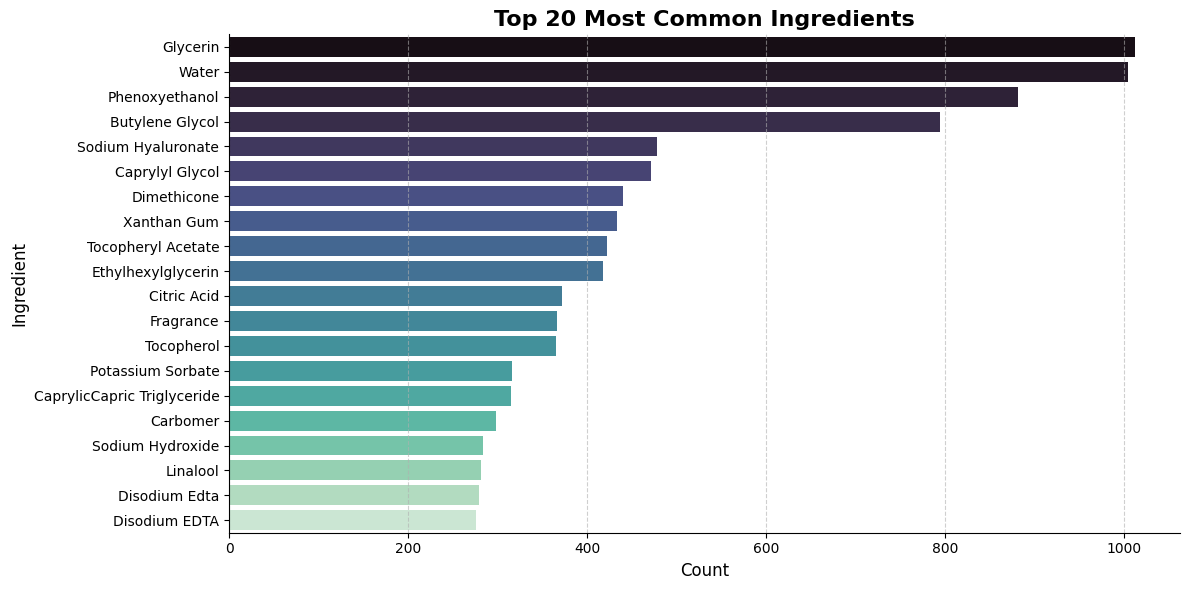

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get gradient colors from the mako palette
colors = sns.color_palette("mako", len(common_ingredients))

# Add a 'Hue' column that duplicates the 'Ingredient' values (for workaround)
common_ingredients['Hue'] = common_ingredients['Ingredient']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=common_ingredients,
    x='Count',
    y='Ingredient',
    hue='Hue',           
    palette=colors,
    legend=False         # Turn off legend (duplicate of y-axis)
)

# Styling
plt.title('Top 20 Most Common Ingredients', fontsize=16, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Ingredient', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()

### The above bar chart shows the most frequently used ingredients across products. Glycerin and water are most common. Third highest is phenoxylethanol which is a synthetic chemical compound found in green tea, used for its anti-bacterial and anti-fungal properties. I used the 'mako' color palette because I thought it was pretty. Throughout my visuals I try to maintain that darker = more and lighter = less.

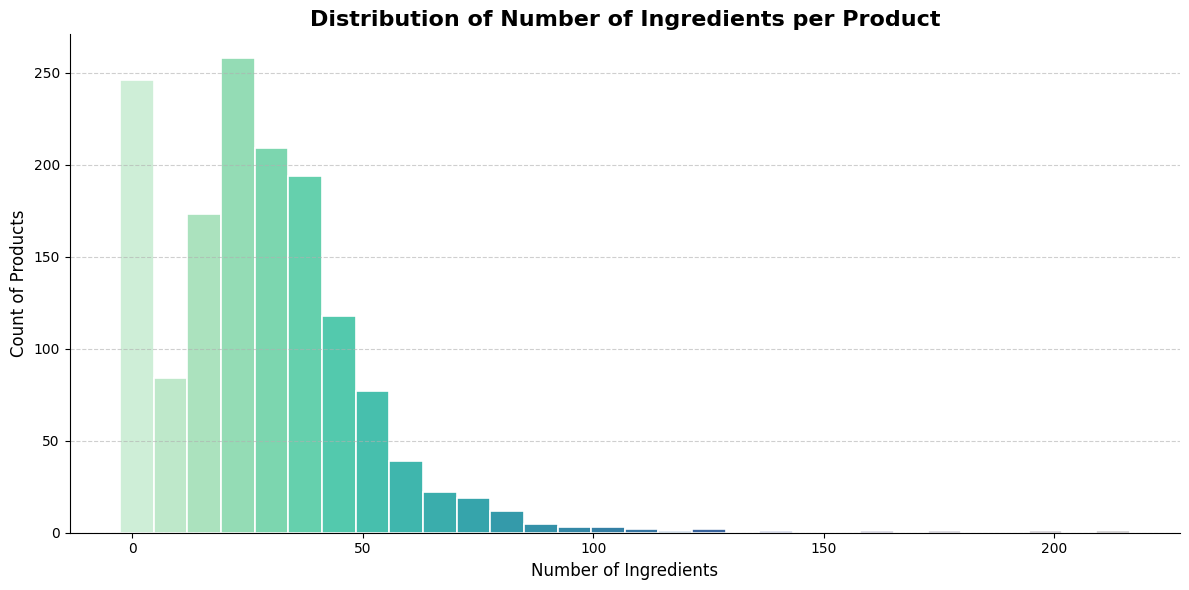

In [13]:
import numpy as np

# Get data
counts, bins = np.histogram(df['num_ingredients'], bins=30)

# Get colors from seaborn's 'mako' palette
colors = sns.color_palette("mako_r", len(counts))

# Create figure
plt.figure(figsize=(12, 6))

# Draw each bar with its own color
for i in range(len(counts)):
    plt.bar(
        bins[i], 
        counts[i], 
        width=(bins[i+1] - bins[i]), 
        color=colors[i], 
        edgecolor='white', 
        linewidth=1.2
    )

# Titles and labels
plt.title('Distribution of Number of Ingredients per Product', fontsize=16, weight='bold')
plt.xlabel('Number of Ingredients', fontsize=12)
plt.ylabel('Count of Products', fontsize=12)

# Style
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()

### Most products contain between one (1) and fifty (50) ingredients.

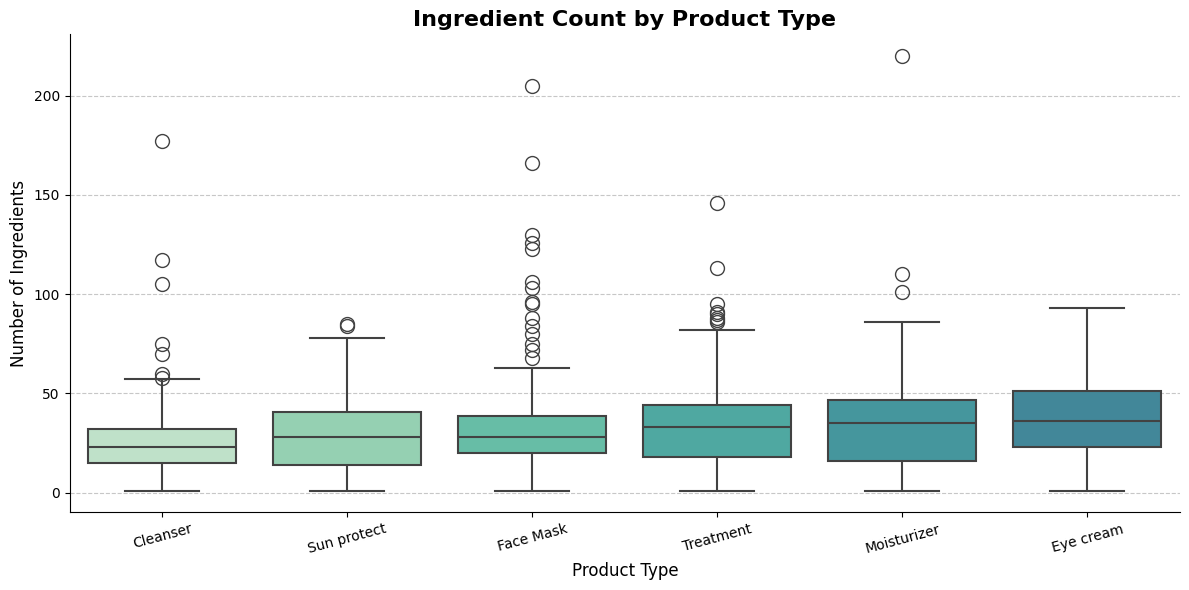

In [14]:
# Step 1: Sort product types by mean num_ingredients (optional, but recommended)
mean_ingredients = df.groupby('product_type')['num_ingredients'].mean().sort_values()
ordered_product_types = mean_ingredients.index

# Step 2: Create mako gradient with one color per product_type
colors = sns.color_palette('mako_r', n_colors=len('product_types'))

# Step 3: Map each product_type to a color
palette = dict(zip(ordered_product_types, colors))

# Step 4: Plot boxplot with custom palette
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='product_type',
    y='num_ingredients',
    hue='product_type',
    order=ordered_product_types,
    palette=palette,
    legend=False,
    linewidth=1.5,
    fliersize=10
)

# Formatting
plt.title('Ingredient Count by Product Type', fontsize=16, weight='bold')
plt.xlabel('Product Type', fontsize=12)
plt.ylabel('Number of Ingredients', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

### Cleansers tend to have the fewest amount of ingredients. Eye cream and sunscreen ingredients don't vary as widely in numbers as the other product types. The bottom-skew of this box plot indicates that most ingredient counts are less than fifty (50) with a number of major outliers.

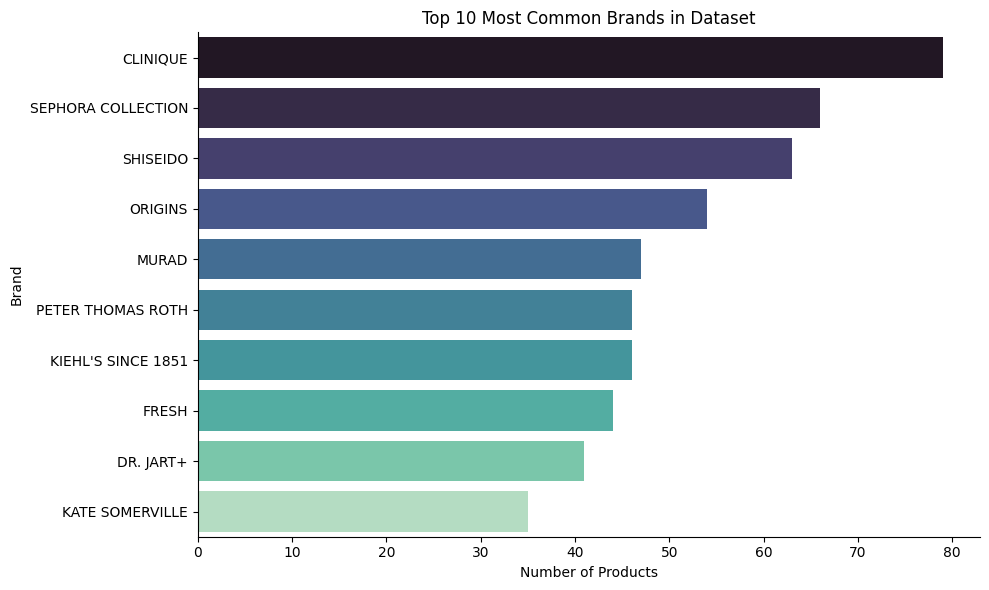

In [15]:
top_brands = df['brand'].value_counts().head(10).reset_index()
top_brands.columns = ['brand', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_brands, x='Count', y='brand', hue='brand', palette='mako', legend=False)
plt.title("Top 10 Most Common Brands in Dataset")
plt.xlabel("Number of Products")
plt.ylabel("Brand")
sns.despine()
plt.tight_layout()
plt.show()

### The bar chart above shows the top 10 most frequent brands in the dataset. These brands have the largest number of products listed, which at least highlight their popularity in the dataset but also could indicate their market dominance.

In [16]:
# Only keep rows where rank is not null or invalid
df_ranked = df.dropna(subset=['rank'])
df_ranked = df_ranked[df_ranked['rank'] > 0]  # optional if 0 means unranked

# Calculate average rank per brand
brand_avg_rank = df_ranked.groupby('brand')['rank'].mean().reset_index()

# Sort by highest average rank (best-rated brands at the top)
top_brands = brand_avg_rank.sort_values(by='rank', ascending=False)

# Show top 10 highest rated brands
print(top_brands.head(10))


             brand      rank
80     NURSE JAMIE  5.000000
18      CLARISONIC  5.000000
8        BIOEFFECT  4.900000
42           GO-TO  4.850000
88  PRIVATE DOCTOR  4.800000
90      SAND & SKY  4.700000
79          NUFACE  4.700000
10        BLACK UP  4.700000
73      MOON JUICE  4.700000
31     ERNO LASZLO  4.628571


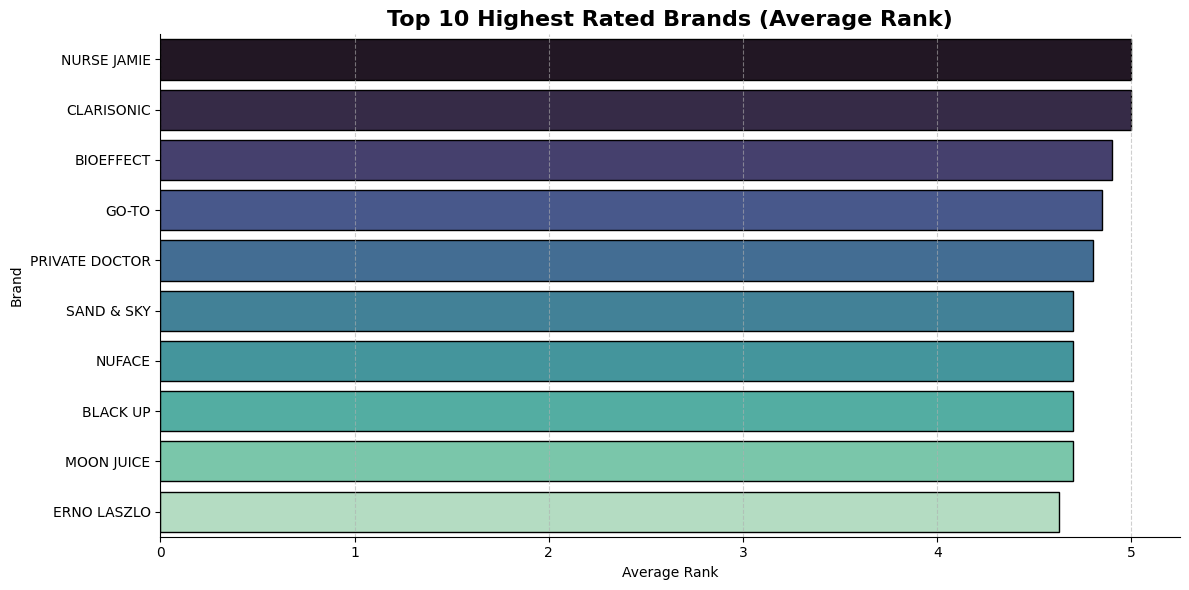

In [17]:
# Take top 10
top_10 = top_brands.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='rank',
    y='brand',
    data=top_10,
    hue='brand',
    palette='mako',   
    edgecolor='black'
)

plt.title('Top 10 Highest Rated Brands (Average Rank)', fontsize=16, weight='bold')
plt.xlabel('Average Rank')
plt.ylabel('Brand')
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()



### Only two of these brands ring a bell for me so I'm looking forward to researching further!

In [18]:
# Calculate average rank per brand
brand_avg_rank = df.groupby('brand')['rank'].mean().reset_index()

# Find brand with lowest average rank
lowest_rated_brand = brand_avg_rank.sort_values('rank').head(10)

print(lowest_rated_brand)

                             brand      rank
23                      DERMAFLASH  0.000000
100  ST. TROPEZ TANNING ESSENTIALS  2.400000
39                           FOREO  3.237500
34                         EVE LOM  3.362500
115             YVES SAINT LAURENT  3.400000
75                     MOROCCANOIL  3.580000
56                         KENZOKI  3.633333
5                        BEAUTYBIO  3.660000
97                    SKIN LAUNDRY  3.800000
111                  VITA LIBERATA  3.850000


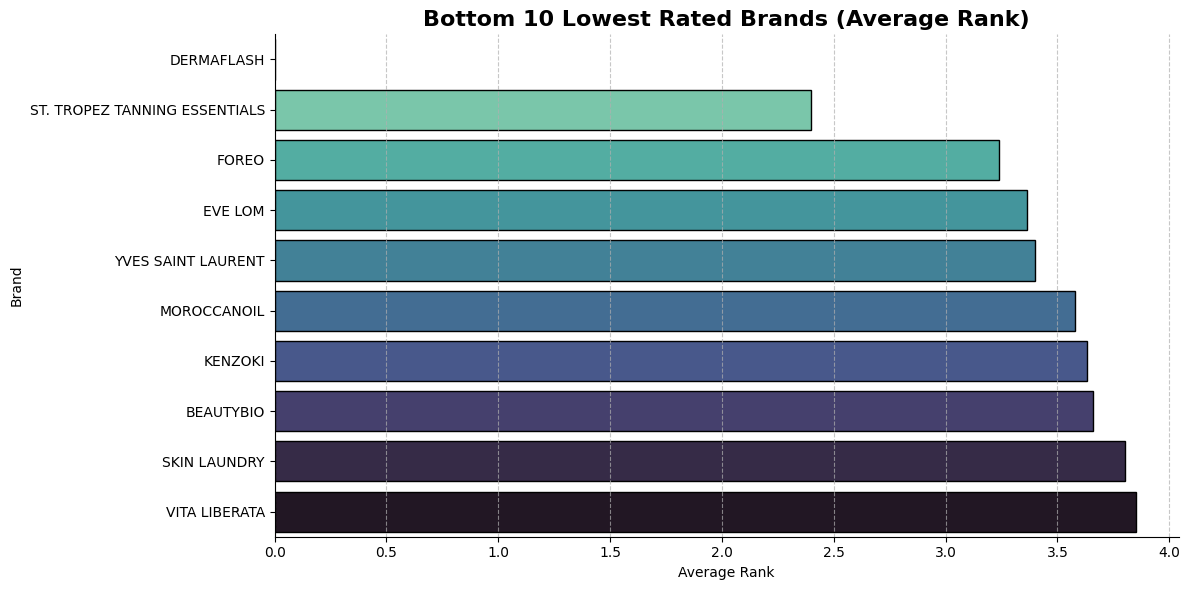

In [19]:
import seaborn as sns

# Get bottom 10 brands by average rank
bottom_brands = brand_avg_rank.sort_values('rank').head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='rank', y='brand', hue='brand', data=bottom_brands, palette='mako_r', edgecolor='black')
plt.title('Bottom 10 Lowest Rated Brands (Average Rank)', fontsize=16, weight='bold')
plt.xlabel('Average Rank')
plt.ylabel('Brand')
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()


### St. Tropez is not ranking with brands that are using newer tanning technologies, but Fenty's low (under 4.0) score is making me question this dataset.

___